<a href="https://colab.research.google.com/github/sruby8/uplift.ai/blob/master/Chart_Uplift_trunk_pelvis_arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

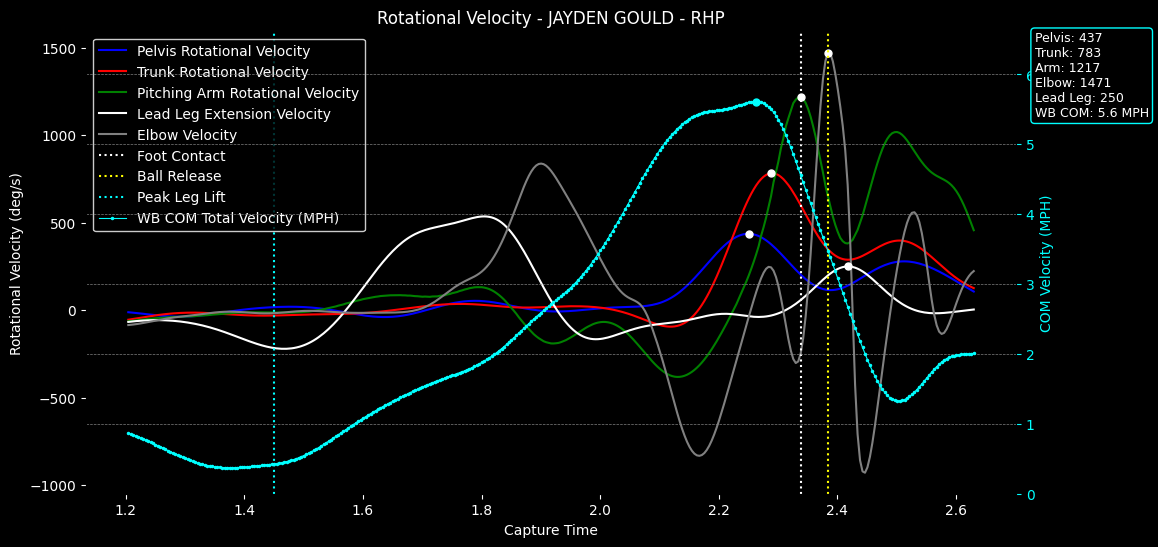

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
file_path = "/content/uplift_data_export_20250515152611.csv"
data = pd.read_csv(file_path)

# Define column names
session_id = "sessionid"
athlete_name_col = "athlete_name"
handedness_col = "handedness"
trunk_velocity_col = "trunk_rotational_velocity_with_respect_to_ground"
pelvis_velocity_col = "pelvis_rotational_velocity_with_respect_to_ground"
left_arm_velocity_col = "left_arm_rotational_velocity_with_respect_to_ground"
right_arm_velocity_col = "right_arm_rotational_velocity_with_respect_to_ground"
left_elbow_velocity_col = "left_elbow_flexion_velocity"
right_elbow_velocity_col = "right_elbow_flexion_velocity"
right_knee_velocity_col = "right_knee_extension_velocity"
left_knee_velocity_col = "left_knee_extension_velocity"
foot_contact_time_col = "foot_contact_time"
ball_release_time_col = "ball_release_time"
time_col = "time"

# Extract athlete name and determine handedness
athlete_name_chart = data[athlete_name_col].iloc[0]
pitcher_handedness = data[handedness_col].iloc[0].lower()
pitcherhand = "LHP" if pitcher_handedness == "left" else "RHP"

# Select appropriate columns based on handedness
arm_velocity_col = left_arm_velocity_col if pitcherhand == "LHP" else right_arm_velocity_col
elbow_velocity_col = left_elbow_velocity_col if pitcherhand == "LHP" else right_elbow_velocity_col
lead_leg_velocity_col = right_knee_velocity_col if pitcherhand == "LHP" else left_knee_velocity_col

# Create subset and calculate WB COM total velocity
subset_data = data[[time_col, trunk_velocity_col, pelvis_velocity_col, arm_velocity_col,
                    elbow_velocity_col, lead_leg_velocity_col, foot_contact_time_col, ball_release_time_col,
                    'whole_body_center_of_mass_x', 'whole_body_center_of_mass_y', 'whole_body_center_of_mass_z']].copy()

fps = data['fps'].iloc[0]
dt = 1 / fps
velocity_x = np.gradient(data['whole_body_center_of_mass_x'], dt)
velocity_y = np.gradient(data['whole_body_center_of_mass_y'], dt)
velocity_z = np.gradient(data['whole_body_center_of_mass_z'], dt)
com_velocity_mph = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2) * 2.23694
subset_data['wb_com_total_velocity_mph'] = com_velocity_mph

# Rename and normalize
if pitcherhand == "LHP":
    subset_data = subset_data.rename(columns={
        pelvis_velocity_col: "pelvis_velocity",
        trunk_velocity_col: "trunk_velocity",
        arm_velocity_col: "arm_velocity",
        lead_leg_velocity_col: "lead_leg_extension_velocity"
    })
    subset_data[["pelvis_velocity", "trunk_velocity", "arm_velocity", "lead_leg_extension_velocity"]] *= -1
else:
    subset_data = subset_data.rename(columns={
        pelvis_velocity_col: "pelvis_velocity",
        trunk_velocity_col: "trunk_velocity",
        arm_velocity_col: "arm_velocity",
        lead_leg_velocity_col: "lead_leg_extension_velocity"
    })
subset_data = subset_data.rename(columns={elbow_velocity_col: "elbow_velocity"})
subset_data["elbow_velocity"] *= -1

# Identify event and peak markers
foot_contact_time = subset_data.loc[subset_data["foot_contact_time"] == 0.0, "time"].min()
ball_release_time = subset_data.loc[subset_data["ball_release_time"] == 0.0, "time"].min()
peak_leg_lift_frame = data.loc[data['max_knee_raise_frame'] == 0, "time"].min()

# Trim window from 0.5s before peak leg lift to 1.0s after ball release
start_time = peak_leg_lift_frame - 0.25
end_time = ball_release_time + 0.25
trimmed_data = subset_data[(subset_data["time"] >= start_time) & (subset_data["time"] <= end_time)]

# Recalculate peaks in trimmed window
def find_local_peak(data, column):
    return data[column].idxmax()

peak_annotations_trimmed = {
    "Pelvis": (trimmed_data["time"].loc[find_local_peak(trimmed_data, "pelvis_velocity")],
               trimmed_data["pelvis_velocity"].max()),
    "Trunk": (trimmed_data["time"].loc[find_local_peak(trimmed_data, "trunk_velocity")],
              trimmed_data["trunk_velocity"].max()),
    "Arm": (trimmed_data["time"].loc[find_local_peak(trimmed_data, "arm_velocity")],
            trimmed_data["arm_velocity"].max()),
    "Elbow": (trimmed_data["time"].loc[find_local_peak(trimmed_data, "elbow_velocity")],
              trimmed_data["elbow_velocity"].max()),
    "WB COM": (trimmed_data["time"].loc[find_local_peak(trimmed_data, "wb_com_total_velocity_mph")],
               trimmed_data["wb_com_total_velocity_mph"].max())
}

# Only evaluate lead leg peak velocity near ball release
time_window = 0.05  # 50ms window
lead_leg_trimmed = trimmed_data[
    (trimmed_data["time"] >= ball_release_time - time_window) &
    (trimmed_data["time"] <= ball_release_time + time_window)
]
lead_leg_peak_idx_trimmed = lead_leg_trimmed["lead_leg_extension_velocity"].idxmax()
peak_annotations_trimmed["Lead Leg"] = (
    subset_data["time"].iloc[lead_leg_peak_idx_trimmed],
    subset_data["lead_leg_extension_velocity"].iloc[lead_leg_peak_idx_trimmed]
)

# Plot trimmed chart
fig, ax1 = plt.subplots(figsize=(12, 6), facecolor="black")
ax1.set_facecolor("black")

ax1.plot(trimmed_data["time"], trimmed_data["pelvis_velocity"], color="blue", label="Pelvis Rotational Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["trunk_velocity"], color="red", label="Trunk Rotational Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["arm_velocity"], color="green", label="Pitching Arm Rotational Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["lead_leg_extension_velocity"], color="white", label="Lead Leg Extension Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["elbow_velocity"], color="gray", label="Elbow Velocity")

for label, (t, val) in peak_annotations_trimmed.items():
    if label != "WB COM":
        ax1.plot(t, val, 'o', color="white", markersize=5)

ax1.set_xlabel("Capture Time", color="white")
ax1.set_ylabel("Rotational Velocity (deg/s)", color="white")
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2 = ax1.twinx()
ax2.plot(trimmed_data["time"], trimmed_data["wb_com_total_velocity_mph"],
         color="cyan", label="WB COM Total Velocity (MPH)", linewidth=0.8, marker='o', markersize=1.5)
ax2.plot(peak_annotations_trimmed["WB COM"][0], peak_annotations_trimmed["WB COM"][1], 'o', color="cyan", markersize=5)
ax2.set_ylabel("COM Velocity (MPH)", color="cyan")
ax2.tick_params(axis='y', colors='cyan')
ax2.set_ylim(0, peak_annotations_trimmed["WB COM"][1] + 1)

if pd.notna(foot_contact_time) and start_time <= foot_contact_time <= end_time:
    ax1.axvline(x=foot_contact_time, color="white", linestyle="dotted", label="Foot Contact")
if pd.notna(ball_release_time) and start_time <= ball_release_time <= end_time:
    ax1.axvline(x=ball_release_time, color="yellow", linestyle="dotted", label="Ball Release")
if pd.notna(peak_leg_lift_frame) and start_time <= peak_leg_lift_frame <= end_time:
    ax1.axvline(x=peak_leg_lift_frame, color="cyan", linestyle="dotted", label="Peak Leg Lift")

summary_text_trimmed = "\n".join([
    f"Pelvis: {peak_annotations_trimmed['Pelvis'][1]:.0f}",
    f"Trunk: {peak_annotations_trimmed['Trunk'][1]:.0f}",
    f"Arm: {peak_annotations_trimmed['Arm'][1]:.0f}",
    f"Elbow: {peak_annotations_trimmed['Elbow'][1]:.0f}",
    f"Lead Leg: {peak_annotations_trimmed['Lead Leg'][1]:.0f}",
    f"WB COM: {peak_annotations_trimmed['WB COM'][1]:.1f} MPH"
])
plt.text(1.02, 1.0, summary_text_trimmed, transform=ax1.transAxes,
         fontsize=9, verticalalignment='top', color='white',
         bbox=dict(boxstyle="round,pad=0.3", edgecolor="cyan", facecolor="black"))

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, facecolor="black", edgecolor="white", labelcolor="white")

plt.title(f"Rotational Velocity - {athlete_name_chart} - {pitcherhand}", color="white")
plt.grid(color="gray", linestyle="--", linewidth=0.5)
plt.show()

